In [1]:
from snowflake.snowpark.session import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark.window import Window
from sklearn.model_selection import train_test_split

import sys
import getpass
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
from connector import sfcon

session = sfcon.connect()

connection successful!


In [3]:
session.sql('USE DATABASE HOL_DB').collect()
session.sql('USE schema PUBLIC').collect()
session.sql('USE warehouse HOL_WH').collect()

[Row(status='Statement executed successfully.')]

In [4]:
session.sql("show databases").show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"created_on"                      |"name"     |"is_default"  |"is_current"  |"origin"                 |"owner"         |"comment"  |"options"  |"retention_time"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
|2022-12-18 06:02:51.495000-08:00  |HOL_DB     |N             |Y             |                         |ACCOUNTADMIN    |           |           |1                 |
|2022-12-11 04:04:59.800000-08:00  |ML_E2E     |N             |N             |                         |DATA_SCIENTIST  |           |           |1                 |
|2022-11-15 19:29:04.242000-08:00  |SNOWFLAKE  |N             |N             |SNOWFLAKE.ACCOUNT_USAGE  |                |           |           |1                 |
----------

In this article, we will learn how to use snowpark python api for
 - Data Preprocessing
 - Feature engineering
 - Build machine learning model and,
 - Save trained models as UDFs (User defined functions) in snowflake
 
 Let's begins

In [5]:
df = pd.read_csv("data/Covid Data.csv.zip")

In [6]:
df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


In [7]:
df.shape

(1048575, 21)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-null  int64 
 15

```
Dataset description

sex: 1 for female and 2 for male.
age: of the patient.
classification: covid test findings. Values 1-3 mean that the patient was diagnosed with covid in different
degrees. 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive.
patient type: type of care the patient received in the unit. 1 for returned home and 2 for hospitalization.
pneumonia: whether the patient already have air sacs inflammation or not.
pregnancy: whether the patient is pregnant or not.
diabetes: whether the patient has diabetes or not.
copd: Indicates whether the patient has Chronic obstructive pulmonary disease or not.
asthma: whether the patient has asthma or not.
inmsupr: whether the patient is immunosuppressed or not.
hypertension: whether the patient has hypertension or not.
cardiovascular: whether the patient has heart or blood vessels related disease.
renal chronic: whether the patient has chronic renal disease or not.
other disease: whether the patient has other disease or not.
obesity: whether the patient is obese or not.
tobacco: whether the patient is a tobacco user.
usmr: Indicates whether the patient treated medical units of the first, second or third level.
medical unit: type of institution of the National Health System that provided the care.
intubed: whether the patient was connected to the ventilator.
icu: Indicates whether the patient had been admitted to an Intensive Care Unit.
date died: If the patient died indicate the date of death, and 9999-99-99 otherwise.
```

In [9]:
#let's write dataset into snowflake
session.write_pandas(df, table_name='COVID19_RECORDS', auto_create_table=True, overwrite=True)

In [10]:
#check tables available in current sechama
session.sql('show tables').show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"created_on"                      |"name"                         |"database_name"  |"schema_name"  |"kind"  |"comment"  |"cluster_by"  |"rows"   |"bytes"   |"owner"       |"retention_time"  |"automatic_clustering"  |"change_tracking"  |"is_external"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|2022-12-18 06:04:48.640000-08:00  |APPLICATION_RECORD             |HOL_DB           |PUBLIC         |TABLE   |           |              |438557   |3974656   |ACCOUNTADMIN  |1                 |OFF                     |OFF              

# Preprocessing

In [11]:
snowpark_df = session.table("COVID19_RECORDS")

In [12]:
type(snowpark_df)

snowflake.snowpark.table.Table

In [13]:
print(f"Size of the table object: {(sys.getsizeof(snowpark_df)/1e6)} MB")

Size of the table object: 4.8e-05 MB


In [14]:
import snowflake
?snowflake.snowpark.table.Table

Init signature:
snowflake.snowpark.table.Table(
    table_name: str,
    session: Union[ForwardRef('snowflake.snowpark.session.Session'), NoneType] = None,
) -> None
Docstring:     
Represents a lazily-evaluated Table. It extends :class:`DataFrame` so all
:class:`DataFrame` operations can be applied to it.

You can create a :class:`Table` object by calling :meth:`Session.table`
with the name of the table in Snowflake. See examples in :meth:`Session.table`.
File:           c:\users\ransaka_09914\anaconda3\envs\getting_started_snowpark_python\lib\site-packages\snowflake\snowpark\table.py
Type:           type
Subclasses:     


In [15]:
snowpark_df.count()

1048575

In [16]:
len(snowpark_df.columns)

21

In [17]:
snowpark_df.schema.fields

[StructField('USMER', LongType(), nullable=True),
 StructField('MEDICAL_UNIT', LongType(), nullable=True),
 StructField('SEX', LongType(), nullable=True),
 StructField('PATIENT_TYPE', LongType(), nullable=True),
 StructField('DATE_DIED', StringType(), nullable=True),
 StructField('INTUBED', LongType(), nullable=True),
 StructField('PNEUMONIA', LongType(), nullable=True),
 StructField('AGE', LongType(), nullable=True),
 StructField('PREGNANT', LongType(), nullable=True),
 StructField('DIABETES', LongType(), nullable=True),
 StructField('COPD', LongType(), nullable=True),
 StructField('ASTHMA', LongType(), nullable=True),
 StructField('INMSUPR', LongType(), nullable=True),
 StructField('HIPERTENSION', LongType(), nullable=True),
 StructField('OTHER_DISEASE', LongType(), nullable=True),
 StructField('CARDIOVASCULAR', LongType(), nullable=True),
 StructField('OBESITY', LongType(), nullable=True),
 StructField('RENAL_CHRONIC', LongType(), nullable=True),
 StructField('TOBACCO', LongType(), 

In [18]:
for column in snowpark_df:
    print(column,'has',snowpark_df[[column]].distinct().count(),'unique values')

Column["USMER"] has 2 unique values
Column["MEDICAL_UNIT"] has 13 unique values
Column["SEX"] has 2 unique values
Column["PATIENT_TYPE"] has 2 unique values
Column["DATE_DIED"] has 401 unique values
Column["INTUBED"] has 4 unique values
Column["PNEUMONIA"] has 3 unique values
Column["AGE"] has 121 unique values
Column["PREGNANT"] has 4 unique values
Column["DIABETES"] has 3 unique values
Column["COPD"] has 3 unique values
Column["ASTHMA"] has 3 unique values
Column["INMSUPR"] has 3 unique values
Column["HIPERTENSION"] has 3 unique values
Column["OTHER_DISEASE"] has 3 unique values
Column["CARDIOVASCULAR"] has 3 unique values
Column["OBESITY"] has 3 unique values
Column["RENAL_CHRONIC"] has 3 unique values
Column["TOBACCO"] has 3 unique values
Column["CLASIFFICATION_FINAL"] has 7 unique values
Column["ICU"] has 4 unique values


In [19]:
snowpark_df.select("SEX").show()

---------
|"SEX"  |
---------
|1      |
|2      |
|2      |
|1      |
|2      |
|1      |
|1      |
|1      |
|1      |
|1      |
---------



In [20]:
snowpark_df[['CLASIFFICATION_FINAL']].describe().show()

--------------------------------------
|"SUMMARY"  |"CLASIFFICATION_FINAL"  |
--------------------------------------
|count      |1048575.0               |
|mean       |5.305653                |
|stddev     |1.8811653303205436      |
|max        |7.0                     |
|min        |1.0                     |
--------------------------------------



In [21]:
snowpark_df.group_by("CLASIFFICATION_FINAL").count().show()

------------------------------------
|"CLASIFFICATION_FINAL"  |"COUNT"  |
------------------------------------
|3                       |381527   |
|5                       |26091    |
|7                       |499250   |
|6                       |128133   |
|1                       |8601     |
|2                       |1851     |
|4                       |3122     |
------------------------------------



```sql 
SELECT
    "USMER",
    "MEDICAL_UNIT",
    "SEX",
    "PATIENT_TYPE",
    "DATE_DIED",
    "INTUBED",
    "PNEUMONIA",
    "AGE",
    "PREGNANT",
    "DIABETES",
    "COPD",
    "ASTHMA",
    "INMSUPR",
    "HIPERTENSION",
    "OTHER_DISEASE",
    "CARDIOVASCULAR",
    "OBESITY",
    "RENAL_CHRONIC",
    "TOBACCO",
    "CLASIFFICATION_FINAL",
    "ICU",
    CASE
        WHEN ("CLASIFFICATION_FINAL" < 4 :: INT) THEN 1 :: INT
        ELSE 0 :: INT
    END AS "TARGET"
FROM
    COVID19_RECORDS
```

In [22]:
snowpark_df = snowpark_df.with_column('TARGET', F.when(F.col('CLASIFFICATION_FINAL')
                        < 4, 1).otherwise(0))

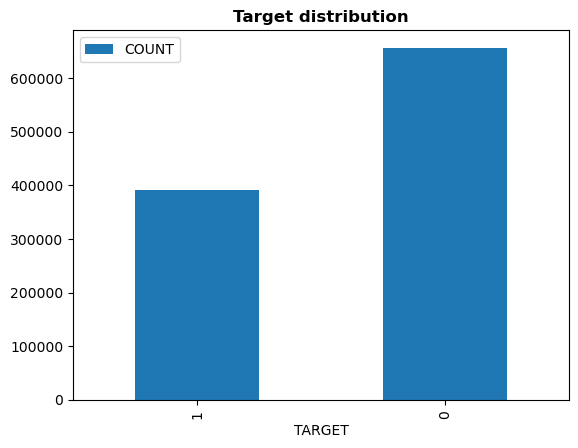

In [23]:
snowpark_df\
.group_by("TARGET").count().to_pandas().set_index("TARGET")\
.plot.bar()

plt.title("Target distribution",fontweight='semibold')
plt.show()

In [24]:
snowpark_df = snowpark_df.replace([97,99],value=None)

Input key or value type doesn't match the target column data type, this replacement was skipped. Column Name: "DATE_DIED", Type: StringType(), Input Key: 97, Type: <class 'int'>, Input Value: None, Type: <class 'NoneType'>
Input key or value type doesn't match the target column data type, this replacement was skipped. Column Name: "DATE_DIED", Type: StringType(), Input Key: 99, Type: <class 'int'>, Input Value: None, Type: <class 'NoneType'>


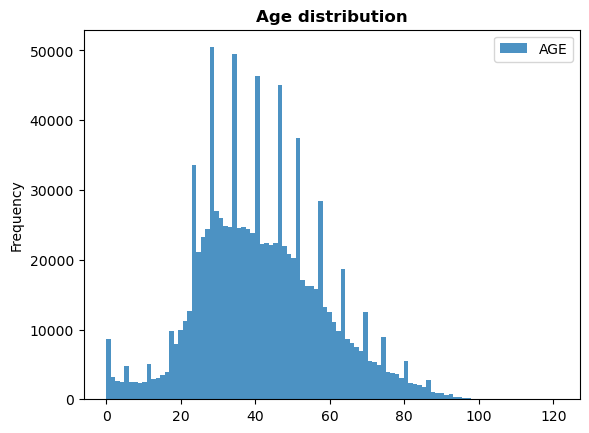

In [25]:
snowpark_df\
.select('AGE').to_pandas()\
.plot.hist(bins=100,alpha=0.8)

plt.title("Age distribution",fontweight='semibold')
plt.show()

In [26]:
snowpark_df.select(F.when(F.col('AGE') < 21, 'YOUNG'
                   ).otherwise(F.when(F.col('AGE') < 49, 'ADULT'
                   ).otherwise('OLD ADULT')).as_('OO'), 'AGE').show()

---------------------
|"OO"       |"AGE"  |
---------------------
|OLD ADULT  |65     |
|OLD ADULT  |72     |
|OLD ADULT  |55     |
|OLD ADULT  |53     |
|OLD ADULT  |68     |
|ADULT      |40     |
|OLD ADULT  |64     |
|OLD ADULT  |64     |
|ADULT      |37     |
|ADULT      |25     |
---------------------



In [27]:
snowpark_df = snowpark_df.with_column(
    "AGE_BKT",
    F.when(F.col("AGE") < 21, "YOUNG").otherwise(
        F.when(F.col("AGE") < 49, "ADULT").otherwise("OLD ADULT")
    ),
)

In [28]:
age_bkt_df = snowpark_df.select(
    F.col("AGE_BKT"),
    F.when((F.col("AGE_BKT")=='YOUNG') & (F.col("TARGET")==1),1).otherwise(0).as_("YOUNG_"),
    F.when((F.col("AGE_BKT")=='ADULT') & (F.col("TARGET")==1),1).otherwise(0).as_("ADULT_"),
    F.when((F.col("AGE_BKT")=='OLD ADULT') & (F.col("TARGET")==1),1).otherwise(0).as_("OLD_ADULT_")
)

In [29]:
age_bkt_df.group_by(F.col("AGE_BKT")).count().show()

-----------------------
|"AGE_BKT"  |"COUNT"  |
-----------------------
|OLD ADULT  |342413   |
|ADULT      |628554   |
|YOUNG      |77608    |
-----------------------



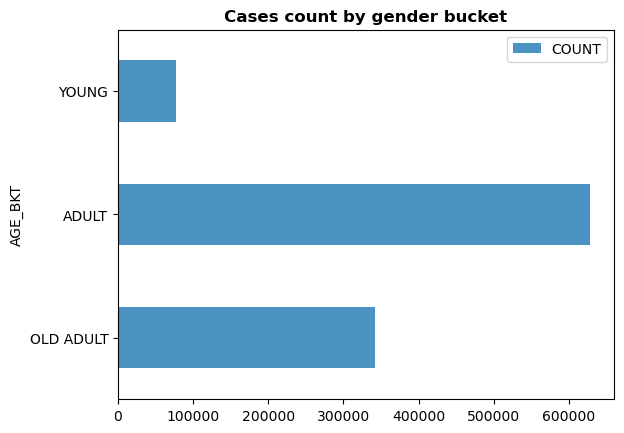

In [30]:
age_bkt_df.group_by(F.col("AGE_BKT")).count().to_pandas().set_index("AGE_BKT")\
.plot.barh(alpha=0.8)

plt.title("Cases count by gender bucket",fontweight='semibold')
plt.show()

In [31]:
age_bkt_df.select(
    ((F.sum("YOUNG_") * 100 ) / F.count("YOUNG_")).as_("YOUNG % OF CASES"),
    ((F.sum("ADULT_") * 100) / F.count("ADULT_")).as_("ADULT % OF CASES"),
    ((F.sum("OLD_ADULT_") * 100) / F.count("OLD_ADULT_")).as_("OLD_ADULT % OF CASES")
).show()

--------------------------------------------------------------------
|"YOUNG % OF CASES"  |"ADULT % OF CASES"  |"OLD_ADULT % OF CASES"  |
--------------------------------------------------------------------
|1.534463            |20.877858           |14.969745               |
--------------------------------------------------------------------



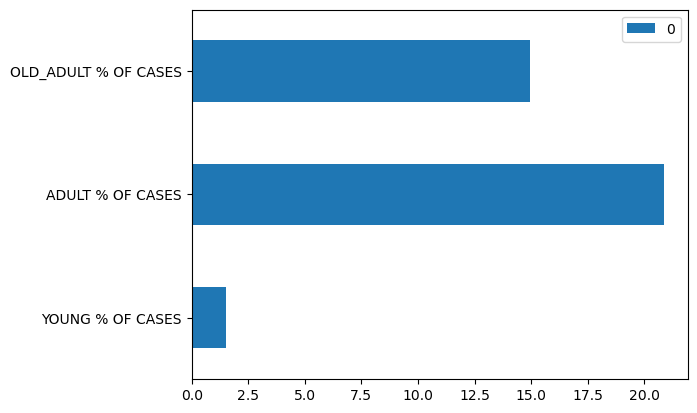

In [32]:
age_bkt_df.select(
    (F.as_double((F.sum("YOUNG_") ) * 100 / F.count("YOUNG_"))).as_("YOUNG % OF CASES"),
    (F.as_double((F.sum("ADULT_")) * 100 / F.count("ADULT_"))).as_("ADULT % OF CASES"),
    (F.as_double((F.sum("OLD_ADULT_")) * 100 / F.count("OLD_ADULT_"))).as_("OLD_ADULT % OF CASES")
).to_pandas().T\
.plot.barh()

plt.show()

In [33]:
for col in snowpark_df.columns:
    snowpark_df.with_column(f"IS_{col}_NULL",F.when(F.is_null(col),"YES").otherwise("NO")).group_by(f'IS_{col}_NULL').count().show()

-----------------------------
|"IS_USMER_NULL"  |"COUNT"  |
-----------------------------
|NO               |1048575  |
-----------------------------

------------------------------------
|"IS_MEDICAL_UNIT_NULL"  |"COUNT"  |
------------------------------------
|NO                      |1048575  |
------------------------------------

---------------------------
|"IS_SEX_NULL"  |"COUNT"  |
---------------------------
|NO             |1048575  |
---------------------------

------------------------------------
|"IS_PATIENT_TYPE_NULL"  |"COUNT"  |
------------------------------------
|NO                      |1048575  |
------------------------------------

---------------------------------
|"IS_DATE_DIED_NULL"  |"COUNT"  |
---------------------------------
|NO                   |1048575  |
---------------------------------

-------------------------------
|"IS_INTUBED_NULL"  |"COUNT"  |
-------------------------------
|YES                |855869   |
|NO                 |192706   |
-----

In [34]:
snowpark_df = snowpark_df.drop(["ICU","DATE_DIED","CLASIFFICATION_FINAL","AGE_BKT"])

In [35]:
snowpark_df.dropna().group_by("TARGET").count().show()

----------------------
|"TARGET"  |"COUNT"  |
----------------------
|1         |41926    |
|0         |36262    |
----------------------



In [36]:
snowpark_df = snowpark_df.dropna()

Also you can check the queries generated as below

In [37]:
# snowpark_df.queries['queries'][0]

``` sql 
SELECT
    *
FROM
    (
        SELECT
            "USMER",
            "MEDICAL_UNIT",
            "SEX",
            "PATIENT_TYPE",
            "DATE_DIED",
            "INTUBED",
            "PNEUMONIA",
            "AGE",
            "PREGNANT",
            "DIABETES",
            "COPD",
            "ASTHMA",
            "INMSUPR",
            "HIPERTENSION",
            "OTHER_DISEASE",
            "CARDIOVASCULAR",
            "OBESITY",
            "RENAL_CHRONIC",
            "TOBACCO",
            "CLASIFFICATION_FINAL",
            "TARGET"
        FROM
            (
                SELECT
                    CASE
                        WHEN ("USMER" = 97 :: INT) THEN NULL
                        WHEN ("USMER" = 99 :: INT) THEN NULL
                        ELSE "USMER"
                    END AS "USMER",
                    CASE
                        WHEN ("MEDICAL_UNIT" = 97 :: INT) THEN NULL
                        WHEN ("MEDICAL_UNIT" = 99 :: INT) THEN NULL
                        ELSE "MEDICAL_UNIT"
                    END AS "MEDICAL_UNIT",
                    CASE
                        WHEN ("SEX" = 97 :: INT) THEN NULL
                        WHEN ("SEX" = 99 :: INT) THEN NULL
                        ELSE "SEX"
                    END AS "SEX",
                    CASE
                        WHEN ("PATIENT_TYPE" = 97 :: INT) THEN NULL
                        WHEN ("PATIENT_TYPE" = 99 :: INT) THEN NULL
                        ELSE "PATIENT_TYPE"
                    END AS "PATIENT_TYPE",
                    "DATE_DIED",
                    CASE
                        WHEN ("INTUBED" = 97 :: INT) THEN NULL
                        WHEN ("INTUBED" = 99 :: INT) THEN NULL
                        ELSE "INTUBED"
                    END AS "INTUBED",
                    CASE
                        WHEN ("PNEUMONIA" = 97 :: INT) THEN NULL
                        WHEN ("PNEUMONIA" = 99 :: INT) THEN NULL
                        ELSE "PNEUMONIA"
                    END AS "PNEUMONIA",
                    CASE
                        WHEN ("AGE" = 97 :: INT) THEN NULL
                        WHEN ("AGE" = 99 :: INT) THEN NULL
                        ELSE "AGE"
                    END AS "AGE",
                    CASE
                        WHEN ("PREGNANT" = 97 :: INT) THEN NULL
                        WHEN ("PREGNANT" = 99 :: INT) THEN NULL
                        ELSE "PREGNANT"
                    END AS "PREGNANT",
                    CASE
                        WHEN ("DIABETES" = 97 :: INT) THEN NULL
                        WHEN ("DIABETES" = 99 :: INT) THEN NULL
                        ELSE "DIABETES"
                    END AS "DIABETES",
                    CASE
                        WHEN ("COPD" = 97 :: INT) THEN NULL
                        WHEN ("COPD" = 99 :: INT) THEN NULL
                        ELSE "COPD"
                    END AS "COPD",
                    CASE
                        WHEN ("ASTHMA" = 97 :: INT) THEN NULL
                        WHEN ("ASTHMA" = 99 :: INT) THEN NULL
                        ELSE "ASTHMA"
                    END AS "ASTHMA",
                    CASE
                        WHEN ("INMSUPR" = 97 :: INT) THEN NULL
                        WHEN ("INMSUPR" = 99 :: INT) THEN NULL
                        ELSE "INMSUPR"
                    END AS "INMSUPR",
                    CASE
                        WHEN ("HIPERTENSION" = 97 :: INT) THEN NULL
                        WHEN ("HIPERTENSION" = 99 :: INT) THEN NULL
                        ELSE "HIPERTENSION"
                    END AS "HIPERTENSION",
                    CASE
                        WHEN ("OTHER_DISEASE" = 97 :: INT) THEN NULL
                        WHEN ("OTHER_DISEASE" = 99 :: INT) THEN NULL
                        ELSE "OTHER_DISEASE"
                    END AS "OTHER_DISEASE",
                    CASE
                        WHEN ("CARDIOVASCULAR" = 97 :: INT) THEN NULL
                        WHEN ("CARDIOVASCULAR" = 99 :: INT) THEN NULL
                        ELSE "CARDIOVASCULAR"
                    END AS "CARDIOVASCULAR",
                    CASE
                        WHEN ("OBESITY" = 97 :: INT) THEN NULL
                        WHEN ("OBESITY" = 99 :: INT) THEN NULL
                        ELSE "OBESITY"
                    END AS "OBESITY",
                    CASE
                        WHEN ("RENAL_CHRONIC" = 97 :: INT) THEN NULL
                        WHEN ("RENAL_CHRONIC" = 99 :: INT) THEN NULL
                        ELSE "RENAL_CHRONIC"
                    END AS "RENAL_CHRONIC",
                    CASE
                        WHEN ("TOBACCO" = 97 :: INT) THEN NULL
                        WHEN ("TOBACCO" = 99 :: INT) THEN NULL
                        ELSE "TOBACCO"
                    END AS "TOBACCO",
                    CASE
                        WHEN ("CLASIFFICATION_FINAL" = 97 :: INT) THEN NULL
                        WHEN ("CLASIFFICATION_FINAL" = 99 :: INT) THEN NULL
                        ELSE "CLASIFFICATION_FINAL"
                    END AS "CLASIFFICATION_FINAL",
                    CASE
                        WHEN ("ICU" = 97 :: INT) THEN NULL
                        WHEN ("ICU" = 99 :: INT) THEN NULL
                        ELSE "ICU"
                    END AS "ICU",
                    CASE
                        WHEN ("TARGET" = 97 :: INT) THEN NULL
                        WHEN ("TARGET" = 99 :: INT) THEN NULL
                        ELSE "TARGET"
                    END AS "TARGET"
                FROM
                    (
                        SELECT
                            "USMER",
                            "MEDICAL_UNIT",
                            "SEX",
                            "PATIENT_TYPE",
                            "DATE_DIED",
                            "INTUBED",
                            "PNEUMONIA",
                            "AGE",
                            "PREGNANT",
                            "DIABETES",
                            "COPD",
                            "ASTHMA",
                            "INMSUPR",
                            "HIPERTENSION",
                            "OTHER_DISEASE",
                            "CARDIOVASCULAR",
                            "OBESITY",
                            "RENAL_CHRONIC",
                            "TOBACCO",
                            "CLASIFFICATION_FINAL",
                            "ICU",
                            CASE
                                WHEN ("CLASIFFICATION_FINAL" < 4 :: INT) THEN 1 :: INT
                                ELSE 0 :: INT
                            END AS "TARGET"
                        FROM
                            (
                                SELECT
                                    *
                                FROM
                                    (COVID19_RECORDS)
                            )
                    )
            )
    )
WHERE
    (
        (
            (
                (
                    (
                        (
                            (
                                (
                                    (
                                        (
                                            (
                                                (
                                                    (
                                                        (
                                                            (
                                                                (
                                                                    (
                                                                        (
                                                                            (
                                                                                (
                                                                                    (
                                                                                        iff("AGE" IS NULL, 0, 1) + iff("INTUBED" IS NULL, 0, 1)
                                                                                    ) + iff("PREGNANT" IS NULL, 0, 1)
                                                                                ) + iff("HIPERTENSION" IS NULL, 0, 1)
                                                                            ) + iff("PNEUMONIA" IS NULL, 0, 1)
                                                                        ) + iff("OTHER_DISEASE" IS NULL, 0, 1)
                                                                    ) + iff("TOBACCO" IS NULL, 0, 1)
                                                                ) + iff("INMSUPR" IS NULL, 0, 1)
                                                            ) + iff("DIABETES" IS NULL, 0, 1)
                                                        ) + iff("TARGET" IS NULL, 0, 1)
                                                    ) + iff("COPD" IS NULL, 0, 1)
                                                ) + iff("CARDIOVASCULAR" IS NULL, 0, 1)
                                            ) + iff("MEDICAL_UNIT" IS NULL, 0, 1)
                                        ) + iff("PATIENT_TYPE" IS NULL, 0, 1)
                                    ) + iff("SEX" IS NULL, 0, 1)
                                ) + iff("DATE_DIED" IS NULL, 0, 1)
                            ) + iff("CLASIFFICATION_FINAL" IS NULL, 0, 1)
                        ) + iff("ASTHMA" IS NULL, 0, 1)
                    ) + iff("OBESITY" IS NULL, 0, 1)
                ) + iff("RENAL_CHRONIC" IS NULL, 0, 1)
            ) + iff("USMER" IS NULL, 0, 1)
        ) >= 21 :: INT
    )
```

In [38]:
snowpark_df.limit(10).to_pandas()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,TARGET
0,2,1,1,2,2,1,40,2,2,2,2,2,2,2,2,2,2,2,1
1,2,1,1,2,2,2,37,2,1,2,2,2,1,2,2,1,2,2,1
2,2,1,1,2,2,2,25,2,2,2,2,2,2,2,2,2,2,2,1
3,2,1,1,2,2,1,80,2,2,2,2,2,1,2,2,2,2,2,1
4,2,1,1,2,1,1,58,2,2,2,2,2,1,2,1,1,2,2,0
5,2,1,1,2,1,1,48,2,1,2,2,2,2,2,2,2,2,2,0
6,2,1,1,2,2,2,25,2,2,2,2,2,2,2,2,2,2,2,0
7,2,1,1,2,2,2,24,2,2,2,2,2,2,2,2,2,2,2,0
8,2,1,1,2,2,2,25,2,2,2,2,2,2,2,2,2,2,2,0
9,2,1,1,2,2,2,30,2,2,2,2,2,2,1,2,2,2,2,0


Write back to snowflake

In [39]:
snowpark_df.write.save_as_table(
    table_name='COVID19_RECORDS_PROCESSED',
    mode='overwrite'
)

In [40]:
del snowpark_df
del df

In [41]:
import gc

gc.collect()

21443

# Model training

In [42]:
train_data = session.table("COVID19_RECORDS_PROCESSED")

In [43]:
train_data.count()

78188

In [44]:
train_data.select(F.sum(F.col("TARGET"))).show()

---------------------
|"SUM(""TARGET"")"  |
---------------------
|41926              |
---------------------



Let's start real model training part

First, create stage for machine learning models, called `ML_MODELS`

In [45]:
session.sql('CREATE OR REPLACE STAGE ML_MODELS').show()

----------------------------------------------
|"status"                                    |
----------------------------------------------
|Stage area ML_MODELS successfully created.  |
----------------------------------------------



In [46]:
def train_dt_procedure(
    session: Session,
    training_table: str,
    feature_cols: list,
    target_col: str,
    model_name: str,
) -> T.Variant:
    
    """
    This will be our training procedure. Later we will register this as snowflake procedure.
    
    training_table: snowflake table name to be used for training task
    feature_cols: list of columns to be used in training
    target_col: target column to be used
    model_name: model name to used for model saving purpose
    
    """

    #convert as pandas DF, rest of the steps similar to the local model training and saving.
    local_training_data = session.table(training_table).to_pandas()

    from sklearn.tree import DecisionTreeClassifier

    X = local_training_data[feature_cols]
    y = local_training_data[target_col]

    model = DecisionTreeClassifier()
    model.fit(X, y)

    feat_importance = pd.DataFrame(
        model.feature_importances_, feature_cols, columns=["FeatImportance"]
    ).to_dict()

    from joblib import dump

    dump(model, "/tmp/" + model_name)
    session.file.put(
        "/tmp/" + model_name, "@ML_MODELS", auto_compress=False, overwrite=True
    )
    return feat_importance


In [47]:
sproc_train_dt_model = session.sproc.register(
                    func=train_dt_procedure, 
                    name='sproc_train_dt_model', 
                    is_permanent=True, 
                    replace=True, 
                    stage_location='@ML_MODELS', 
                    packages=[
                        'snowflake-snowpark-python',
                        'scikit-learn',
                        'joblib']
)

In [48]:
train_data_pd = train_data.to_pandas()

In [49]:
#create train and test dataframes
train_data_pd,test_data_pd = train_test_split(
                                        train_data_pd,
                                        stratify=train_data_pd['TARGET'],
                                        test_size=0.1
)

In [50]:
#writing as tempoary tables for mode training and inferencing part
session.write_pandas(train_data_pd, table_name='TRAIN_DATA_TMP', auto_create_table=True,table_type="temporary")
session.write_pandas(test_data_pd, table_name='TEST_DATA_TMP', auto_create_table=True,table_type="temporary")

In [51]:
feature_cols = train_data.columns
feature_cols.remove('TARGET')
target_col = 'TARGET'
model_name = 'decisiontree.model'

model_response = sproc_train_dt_model('TRAIN_DATA_TMP', 
                                            feature_cols, 
                                            target_col,
                                            model_name, 
                                            session=session
                                           )

In [52]:
print(model_response)

{
  "FeatImportance": {
    "AGE": 0.4495406764847183,
    "ASTHMA": 0.02734844145002929,
    "CARDIOVASCULAR": 0.026163656824010745,
    "COPD": 0.015610870661814366,
    "DIABETES": 0.06058696387222489,
    "HIPERTENSION": 0.06046161472931457,
    "INMSUPR": 0.024452172596442383,
    "INTUBED": 0.025061840298817285,
    "MEDICAL_UNIT": 0.09498782681802134,
    "OBESITY": 0.028268191523668378,
    "OTHER_DISEASE": 0.025908224512469692,
    "PATIENT_TYPE": 0,
    "PNEUMONIA": 0.0412125714132776,
    "PREGNANT": 0.01335446540097891,
    "RENAL_CHRONIC": 0.018501343421274265,
    "SEX": 0,
    "TOBACCO": 0.027695748397739643,
    "USMER": 0.06084539159519835
  }
}


In [53]:
session.sql('LIST @ML_MODELS').show()

-------------------------------------------------------------------------------------------------------------
|"name"                        |"size"   |"md5"                             |"last_modified"                |
-------------------------------------------------------------------------------------------------------------
|ml_models/decisiontree.model  |2618592  |71ccb5ac5ad7739e8c495ee0a989b06a  |Mon, 26 Dec 2022 05:51:59 GMT  |
-------------------------------------------------------------------------------------------------------------



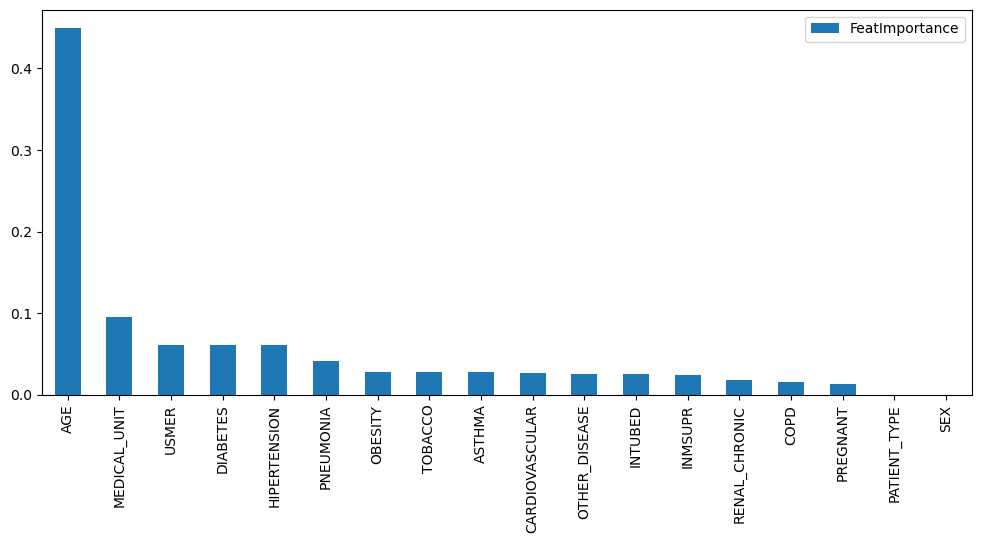

In [54]:
feature_coefficients = pd.DataFrame(eval(model_response))

feature_coefficients\
.sort_values(by='FeatImportance',ascending=False)\
.plot\
.bar(y='FeatImportance', figsize=(12,5))
plt.show()

Let's create UDF for getting model predictions for unseen data

In [55]:
def udf_predict_risk_score(*args) -> float:
    import os
    import sys
    from joblib import load
    
    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]
    model_name = 'decisiontree.model'
    model = load(import_dir+model_name)
    scored_data = model.predict(pd.DataFrame([args]))[0]
    return scored_data

In [56]:
udf_risk_score_model = session.udf.register(
                            func=udf_predict_risk_score, 
                            name="udf_risk_score_model", 
                            stage_location='@ML_MODELS',
                            input_types=[T.FloatType()]*len(feature_cols),
                            return_type = T.FloatType(),
                            replace=True, 
                            is_permanent=True, 
                            imports=['@ML_MODELS/decisiontree.model'],
                            packages=['scikit-learn==1.1.1','pandas','joblib'], 
                            session=session
)

In [57]:
test_data_sf = session.table("TEST_DATA_TMP")

In [58]:
test_data_sf = test_data_sf.with_column('PREDICTION', udf_risk_score_model(*feature_cols))

In [74]:
print(test_data_sf.queries['queries'][0])

SELECT "USMER", "MEDICAL_UNIT", "SEX", "PATIENT_TYPE", "INTUBED", "PNEUMONIA", "AGE", "PREGNANT", "DIABETES", "COPD", "ASTHMA", "INMSUPR", "HIPERTENSION", "OTHER_DISEASE", "CARDIOVASCULAR", "OBESITY", "RENAL_CHRONIC", "TOBACCO", "TARGET", udf_risk_score_model("USMER", "MEDICAL_UNIT", "SEX", "PATIENT_TYPE", "INTUBED", "PNEUMONIA", "AGE", "PREGNANT", "DIABETES", "COPD", "ASTHMA", "INMSUPR", "HIPERTENSION", "OTHER_DISEASE", "CARDIOVASCULAR", "OBESITY", "RENAL_CHRONIC", "TOBACCO") AS "PREDICTION" FROM ( SELECT  *  FROM (TEST_DATA_TMP))


In [71]:
feature_cols

['USMER',
 'MEDICAL_UNIT',
 'SEX',
 'PATIENT_TYPE',
 'INTUBED',
 'PNEUMONIA',
 'AGE',
 'PREGNANT',
 'DIABETES',
 'COPD',
 'ASTHMA',
 'INMSUPR',
 'HIPERTENSION',
 'OTHER_DISEASE',
 'CARDIOVASCULAR',
 'OBESITY',
 'RENAL_CHRONIC',
 'TOBACCO']

In [59]:
def get_model_report(test_df):
    from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,ConfusionMatrixDisplay
    
    target = test_df.select("TARGET").to_pandas()
    predictions = test_df.select("PREDICTION").to_pandas()
    
    cm = confusion_matrix(target,predictions)
    precision = precision_score(target,predictions)
    recall = recall_score(target,predictions)
    f1= f1_score(target,predictions)
    
    print(f"Model perfomances Recall: {recall:.2}, Precision: {precision:.2}\n")
    
    cmd = ConfusionMatrixDisplay(cm)
    cmd.plot()

Model perfomances Recall: 0.53, Precision: 0.54



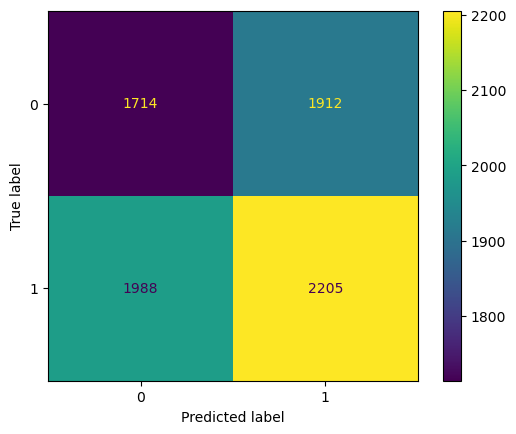

In [60]:
get_model_report(test_df=test_data_sf)

Additionaly we can host locally trained model in snowflake

In [61]:
def train_model_locally(train):
    from sklearn.tree import DecisionTreeClassifier
    
    #convert into pd dataframes
    
    train = train.to_pandas()
    
    xtrain,ytrain = train.drop('TARGET',axis=1),train['TARGET']
    
    model = DecisionTreeClassifier()
    model.fit(xtrain,ytrain)
    
    return model

In [62]:
train_data_sf = session.table("TRAIN_DATA_TMP")

In [63]:
model = train_model_locally(train_data_sf)

In [64]:
import joblib

joblib.dump(model, 'predict_risk_score.joblib')

['predict_risk_score.joblib']

In [65]:
session.file.put(
    "predict_risk_score.joblib", "@ML_MODELS", auto_compress=False, overwrite=True
)

[PutResult(source='predict_risk_score.joblib', target='predict_risk_score.joblib', source_size=2615954, target_size=2615968, source_compression='NONE', target_compression='NONE', status='UPLOADED', message='')]

In [66]:
?session.add_import

Signature: session.add_import(path: str, import_path: Union[str, NoneType] = None) -> None
Docstring:
Registers a remote file in stage or a local file as an import of a user-defined function
(UDF). The local file can be a compressed file (e.g., zip), a Python file (.py),
a directory, or any other file resource. You can also find examples in
:class:`~snowflake.snowpark.udf.UDFRegistration`.

Args:
    path: The path of a local file or a remote file in the stage. In each case:

        * if the path points to a local file, this file will be uploaded to the
          stage where the UDF is registered and Snowflake will import the file when
          executing that UDF.

        * if the path points to a local directory, the directory will be compressed
          as a zip file and will be uploaded to the stage where the UDF is registered
          and Snowflake will import the file when executing that UDF.

        * if the path points to a file in a stage, the file will be included in the

In [67]:
session.clear_imports()
session.clear_packages()
session.add_import("@ML_MODELS/predict_risk_score.joblib")
session.add_packages("joblib==1.1.0", "scikit-learn==1.1.1", "pandas==1.3.2")

In [68]:
from snowflake.snowpark.types import PandasSeries, PandasDataFrame


def read_file(filename):
    import joblib
    import sys
    import os
    
    import_dir = sys._xoptions.get("snowflake_import_directory")
    if import_dir:
        with open(os.path.join(import_dir, filename), 'rb') as file:
            m = joblib.load(file)
            return m

@F.udf(name = 'predict_risk_score', is_permanent = True, replace = True, stage_location = '@ML_MODELS')
def predict_risk_score(ds: PandasSeries[dict]) -> PandasSeries[float]:
    df = pd.io.json.json_normalize(ds)[feature_cols]
    pipeline = read_file('predict_risk_score.joblib')
    return pipeline.predict_proba(df)[:,1]

In [69]:
session.sql("DESC FUNCTION PREDICT_RISK_SCORE()").show()

------------------------------------------------------------------------
|"property"       |"value"                                             |
------------------------------------------------------------------------
|signature        |()                                                  |
|returns          |FLOAT                                               |
|language         |PYTHON                                              |
|null handling    |CALLED ON NULL INPUT                                |
|volatility       |VOLATILE                                            |
|body             |                                                    |
|                 |import pickle                                       |
|                 |                                                    |
|                 |func = pickle.loads(bytes.fromhex('800595050400...  |
|                 |# The following comment contains the UDF source...  |
|                 |# import pandas as pd           

In [70]:
test_data_sf.with_column(
    'PREDICTION', 
    predict_risk_score(F.object_construct('*')))\
.select("TARGET","PREDICTION").show(20)

----------------------------------
|"TARGET"  |"PREDICTION"         |
----------------------------------
|1         |0.0                  |
|0         |1.0                  |
|0         |0.0                  |
|0         |0.0                  |
|1         |0.625                |
|0         |0.6666666666666666   |
|0         |0.8148148148148148   |
|1         |0.4666666666666667   |
|0         |0.5                  |
|0         |0.4375               |
|1         |0.5454545454545454   |
|1         |0.0                  |
|1         |0.8                  |
|1         |1.0                  |
|1         |0.46153846153846156  |
|1         |0.6595744680851063   |
|1         |0.75                 |
|0         |0.0                  |
|0         |0.0                  |
|0         |0.0                  |
----------------------------------

